In [1]:
import os
from tqdm import tqdm 
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# DATA 

In [2]:
stops=pd.read_csv('/kaggle/input/porcodiooo/stops.csv')
stops = stops[
    (stops['LATITUDE'] >= 49.9) & (stops['LATITUDE'] <= 55.8) &
    (stops['LONGITUDE'] >= -6.4) & (stops['LONGITUDE'] <= 1.8)
]

ports=pd.read_csv('/kaggle/input/tutti-i-porti/PORTS.csv')
ports = ports[
    (ports['LATITUDE'] >= 49.9) & (ports['LATITUDE'] <= 55.8) &
    (ports['LONGITUDE'] >= -6.4) & (ports['LONGITUDE'] <= 1.8)
]

# CLUSTERING

In [3]:
X = stops[['LONGITUDE', 'LATITUDE', 'DURATION']].copy()

# Applica DBSCAN a tutto il dataset
dbscan = DBSCAN(eps=0.05, min_samples=10)  # Puoi ottimizzare eps e min_samples
clusters = dbscan.fit_predict(X[['LONGITUDE', 'LATITUDE']])

# Aggiungi i risultati del clustering al dataset originale
stops['cluster'] = clusters

# PLOT

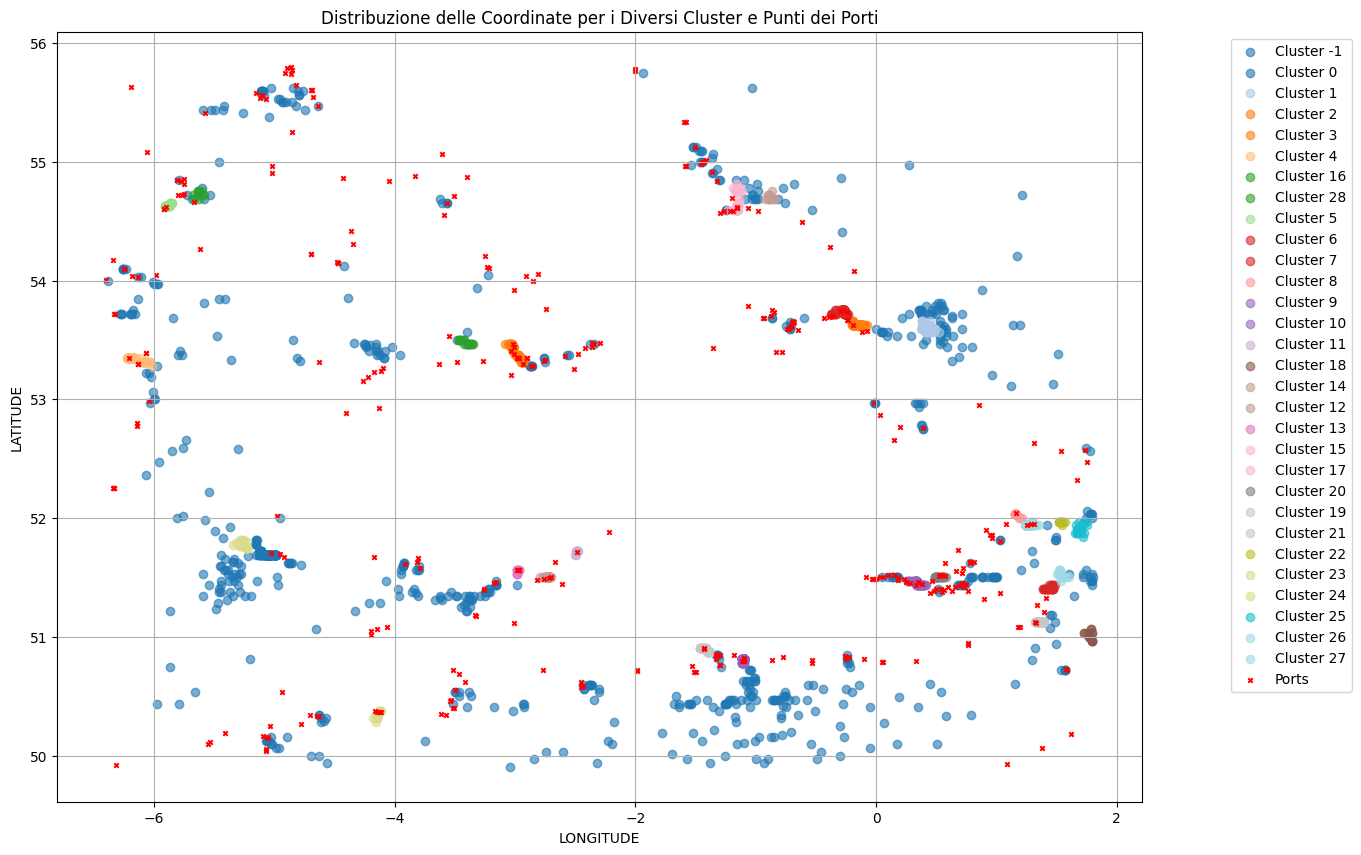

In [4]:


# Supponiamo che tu abbia già il DataFrame 'stops'
clusters = stops['cluster'].unique()

# Usa una mappa di colori da Matplotlib
cmap = plt.get_cmap('tab20', len(clusters))  # 'tab20' è una mappa di colori di base, ma la puoi ampliare con len(clusters)

# Imposta la figura per il grafico
plt.figure(figsize=(14, 10))

# Crea un grafico per ogni cluster
for i, cluster in enumerate(clusters):
    cluster_data = stops[stops['cluster'] == cluster]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], 
                c=[cmap(i)], 
                label=f'Cluster {cluster}', 
                alpha=0.6)

# Aggiungi i punti dei porti
plt.scatter(ports['LONGITUDE'], ports['LATITUDE'], 
            c='red', 
            marker='x', 
            s=10, 
            label='Ports')

# Aggiungi le etichette e il titolo
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Distribuzione delle Coordinate per i Diversi Cluster e Punti dei Porti')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()


# EXPORT

In [5]:
import geopandas as gpd
from shapely.geometry import Point
import os

# Dati d'esempio (sostituisci con il tuo DataFrame 'stops')
# stops = pd.DataFrame({
#     'LONGITUDE': [12.5, 13.5],
#     'LATITUDE': [41.9, 42.9],
#     'STOP_NAME': ['Stop1', 'Stop2']
# })

# Crea la geometria (punti) usando latitudine e longitudine
geometry = [Point(xy) for xy in zip(stops['LONGITUDE'], stops['LATITUDE'])]
gdf = gpd.GeoDataFrame(stops, geometry=geometry)

# Imposta il sistema di riferimento (CRS)
gdf.crs = "EPSG:4326"  # WGS 84

# Crea una cartella per i file di output
output_folder = "shapefile_output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Esporta il GeoDataFrame come shapefile
output_path = os.path.join(output_folder, "output_shapefile.shp")
gdf.to_file(output_path)

print(f"Shapefile salvato nella cartella: {output_folder}")


Shapefile salvato nella cartella: shapefile_output


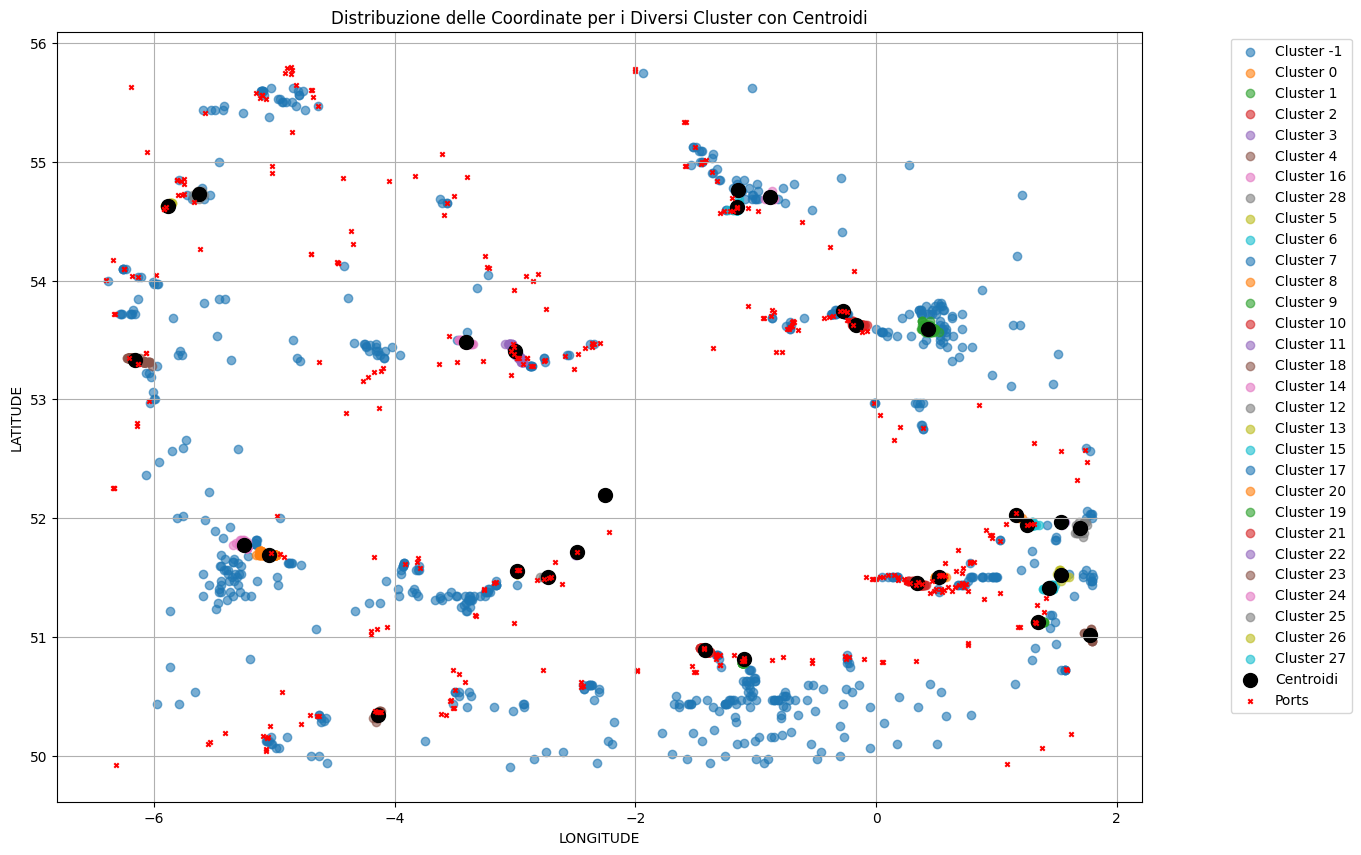

    cluster  CENTROID_LONGITUDE  CENTROID_LATITUDE
0        -1           -2.251109          52.191435
1         0           -5.048496          51.690492
2         1            0.433083          53.595559
3         2           -0.169912          53.625777
4         3           -3.001507          53.404464
5         4           -6.161070          53.334774
6         5           -5.887223          54.631048
7         6            1.438777          51.413462
8         7           -0.278421          53.744853
9         8            1.166199          52.025391
10        9           -1.099734          50.809743
11       10            0.341719          51.456597
12       11           -2.487571          51.713068
13       12           -2.728885          51.500000
14       13           -2.981889          51.551136
15       14           -0.882772          54.700521
16       15           -1.158186          54.619073
17       16           -3.409231          53.480263
18       17           -1.149989

In [6]:

# Trova il centroide per ogni cluster
centroids = stops.groupby('cluster')[['LONGITUDE', 'LATITUDE']].mean().reset_index()
centroids.rename(columns={'LONGITUDE': 'CENTROID_LONGITUDE', 'LATITUDE': 'CENTROID_LATITUDE'}, inplace=True)

# Visualizza i risultati
plt.figure(figsize=(14, 10))

# Grafico dei cluster
for cluster in stops['cluster'].unique():
    cluster_data = stops[stops['cluster'] == cluster]
    plt.scatter(cluster_data['LONGITUDE'], cluster_data['LATITUDE'], 
                label=f'Cluster {cluster}', 
                alpha=0.6)

# Aggiungi i centri dei cluster
plt.scatter(centroids['CENTROID_LONGITUDE'], centroids['CENTROID_LATITUDE'], 
            c='black', 
            marker='o', 
            s=100, 
            label='Centroidi', 
            edgecolor='k')

# Aggiungi i punti dei porti
plt.scatter(ports['LONGITUDE'], ports['LATITUDE'], 
            c='red', 
            marker='x', 
            s=10, 
            label='Ports')

# Aggiungi le etichette e il titolo
plt.xlabel('LONGITUDE')
plt.ylabel('LATITUDE')
plt.title('Distribuzione delle Coordinate per i Diversi Cluster con Centroidi')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

# Stampa i centroidi per verifica
print(centroids)
